Using cuda device


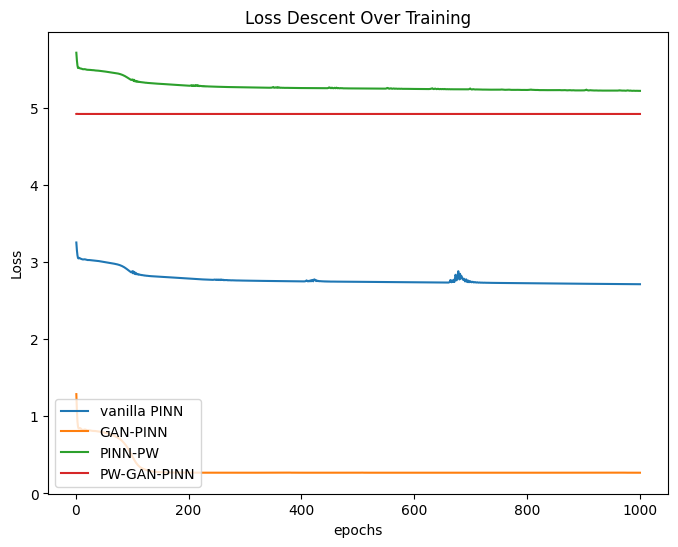

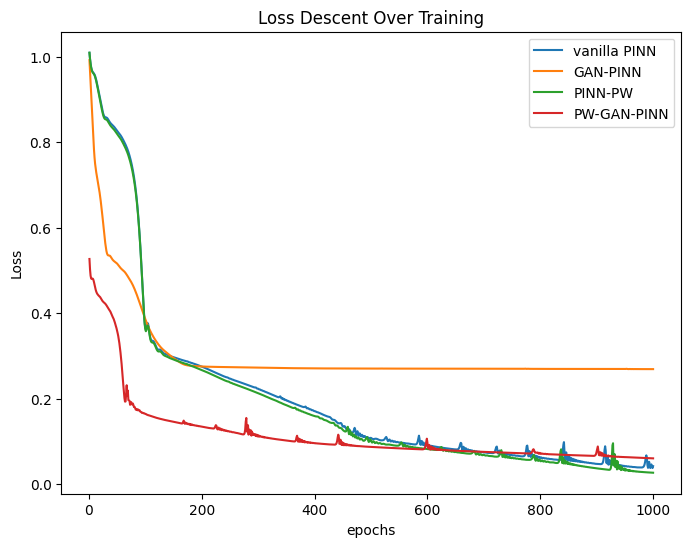

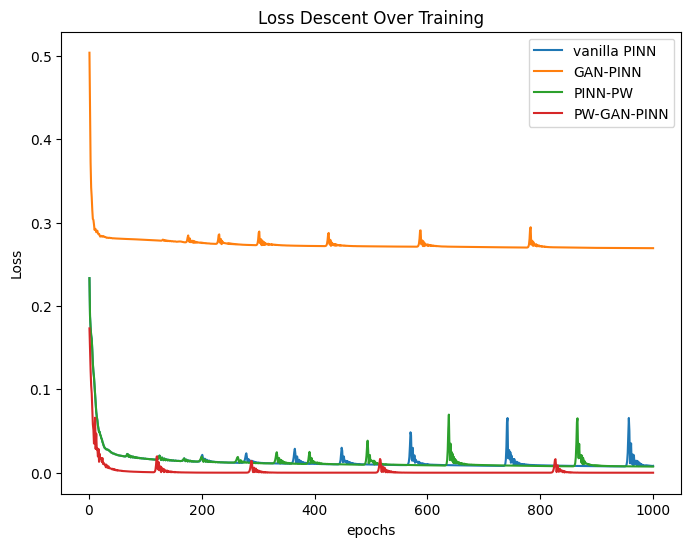

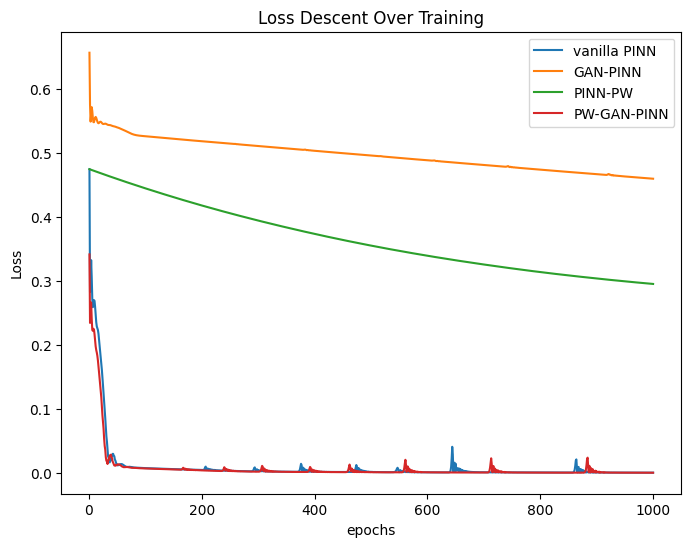

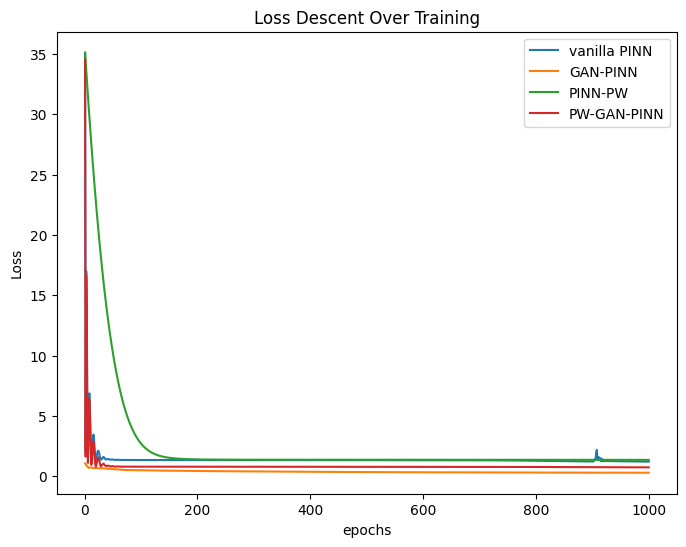

In [2]:
import scipy
from utils.plot import plot_loss_comparison, plot_with_ground_truth, plot_loss
from PDE_PINNs import Heat_PINN_GAN, Schroedinger_PINN_GAN
from data_structuring import structure_data
import pickle
import torch
import numpy as np


pde_list = ['schroedinger', 'burgers', 'heat', 'poisson', 'helmholtz']

model_name = ["paperhyperparams-smaller-e-with-none",
              "paperhyperparams-smaller-e-with-gan",
              "paperhyperparams-smaller-e-with-pw",
              "paperhyperparams-smaller-e-with-all"]

for pde in pde_list:
    loaded_dict = []
    for i in range(len(model_name)):
        with open('Saves/loss_history_'+ pde + "_" +model_name[i]+'.pkl', 'rb') as f:
            loaded_dict.append(pickle.load(f))
    plot_loss_comparison(loaded_dict, model_label_list=["vanilla PINN", "GAN-PINN", "PINN-PW", "PW-GAN-PINN"], filename='Plots/'+ pde + '_loss_comparison.png')

model is loading...Done.


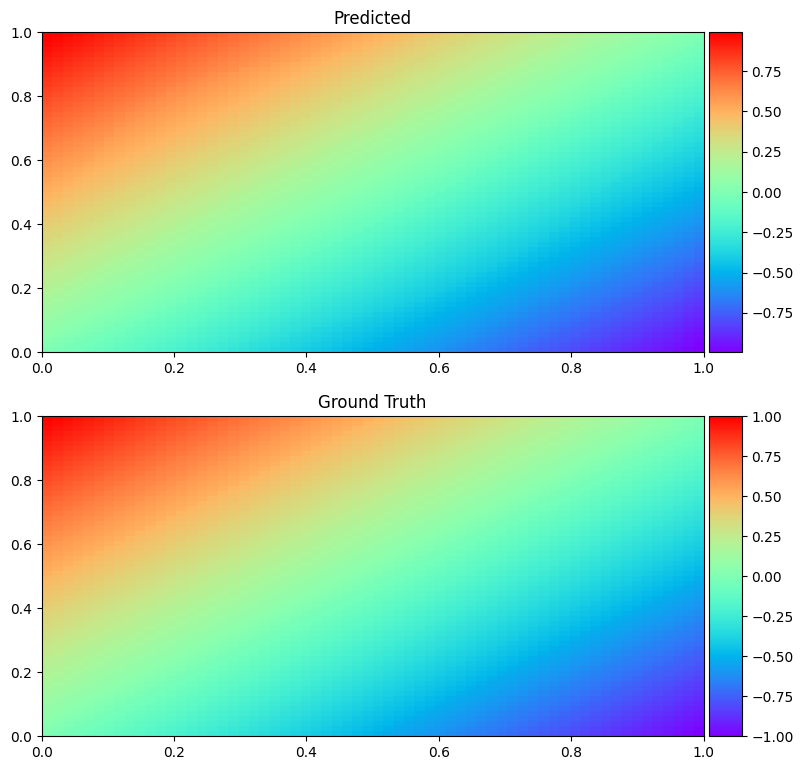

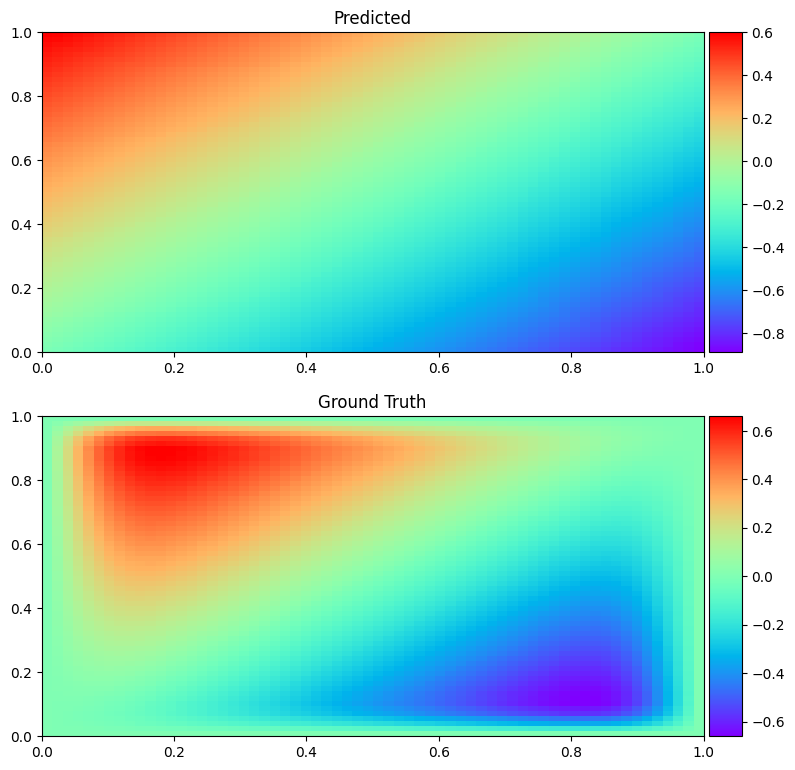

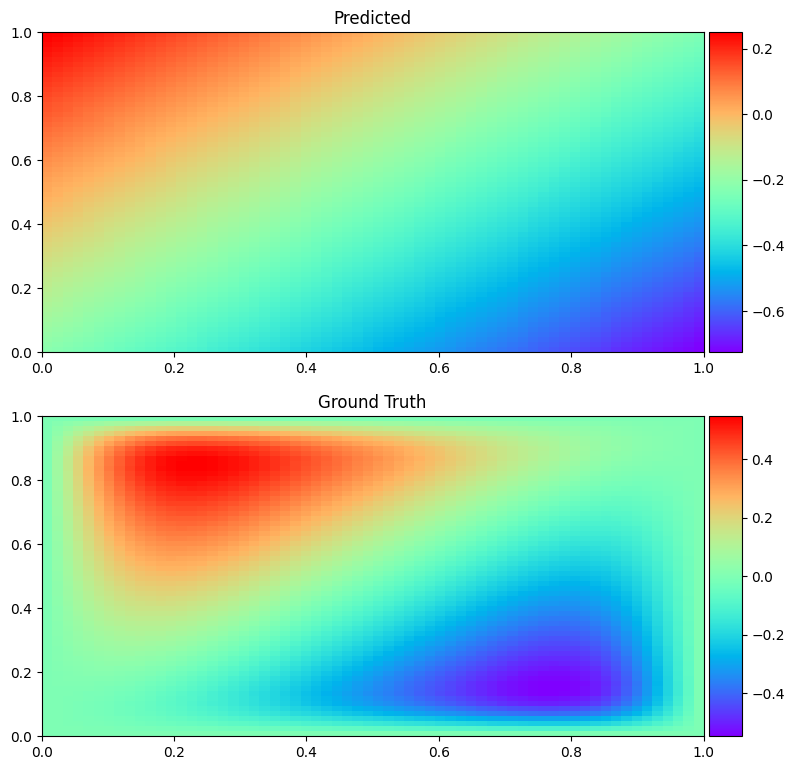

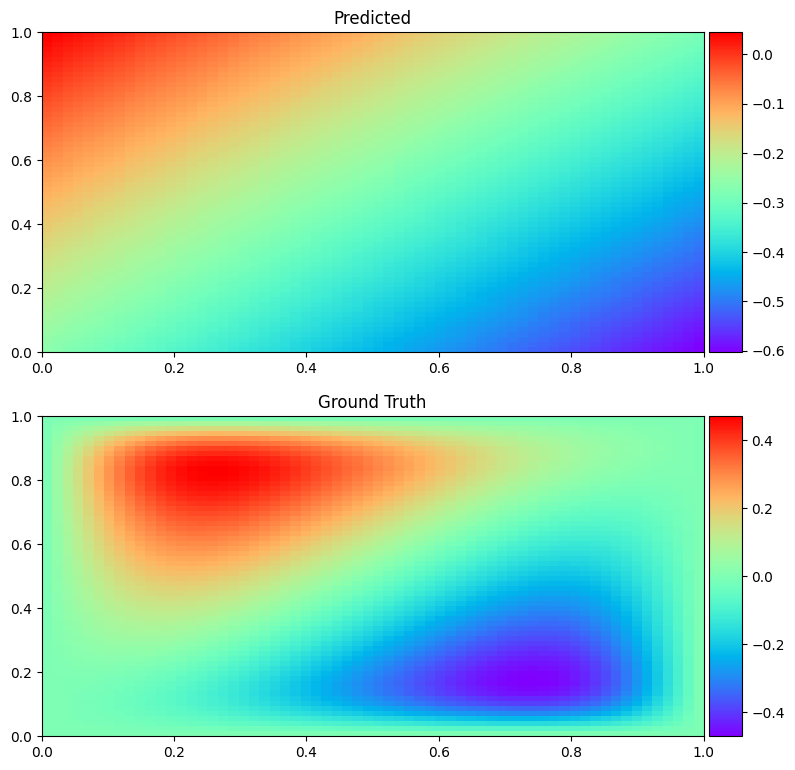

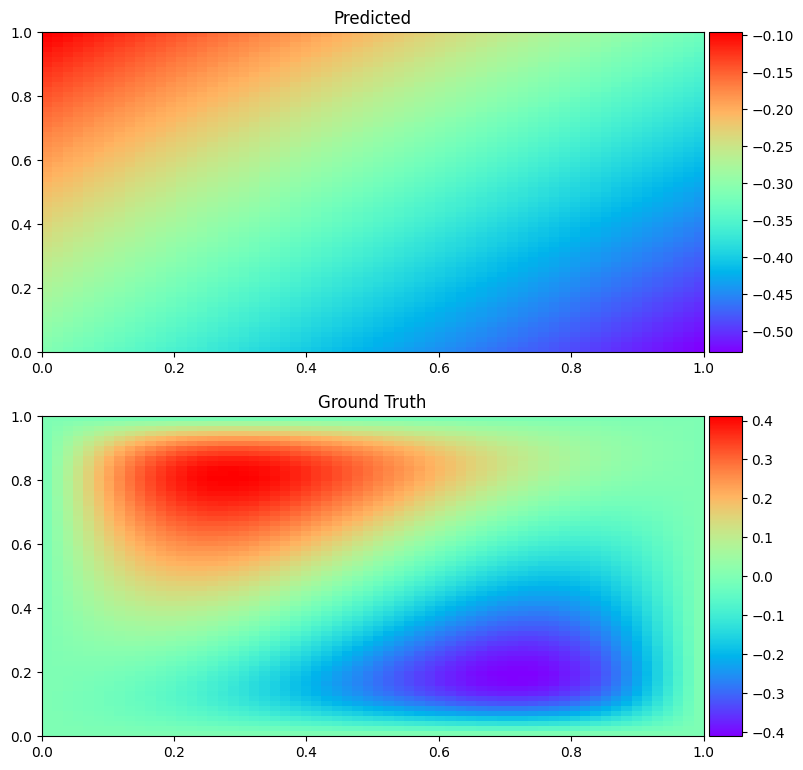

Error y:  1.1663504263747997
model is loading...Done.


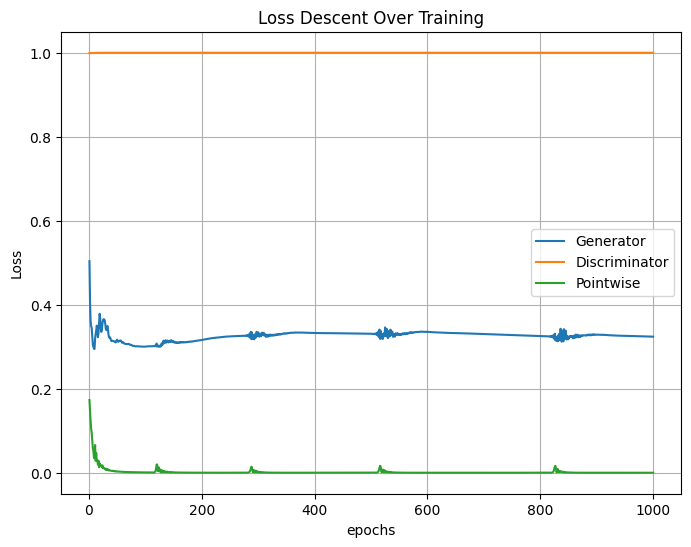

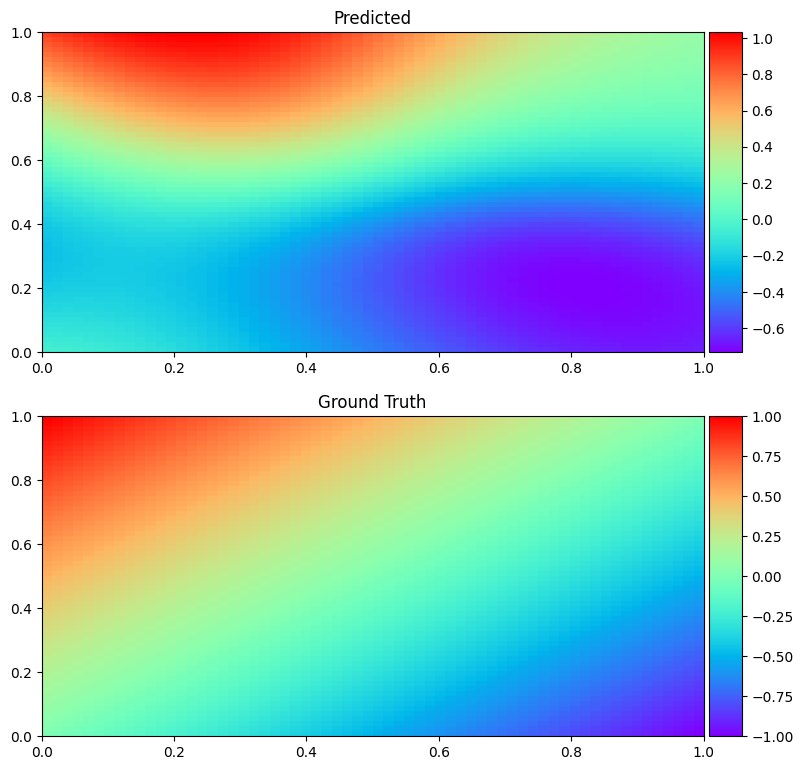

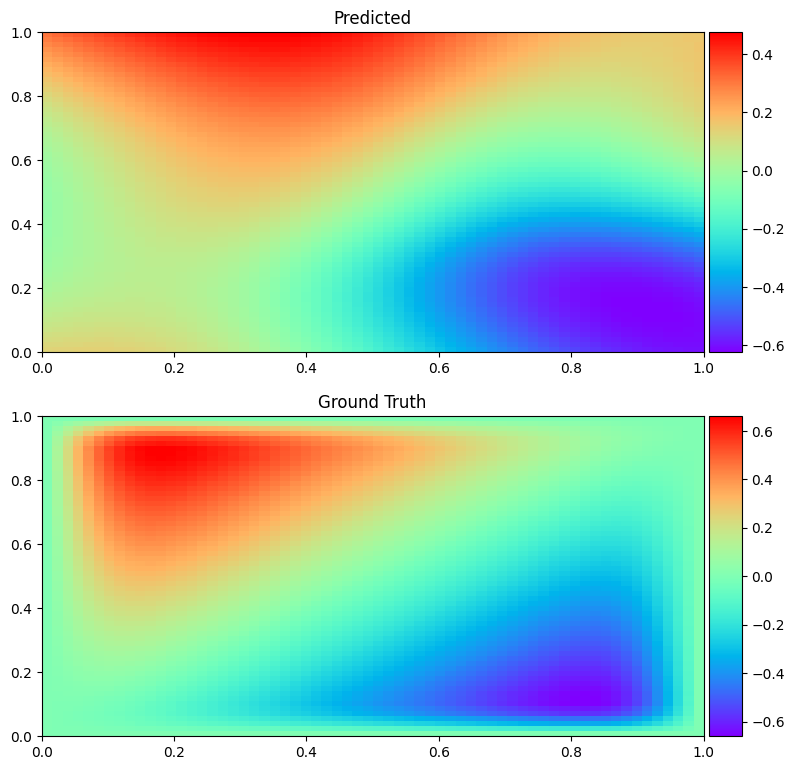

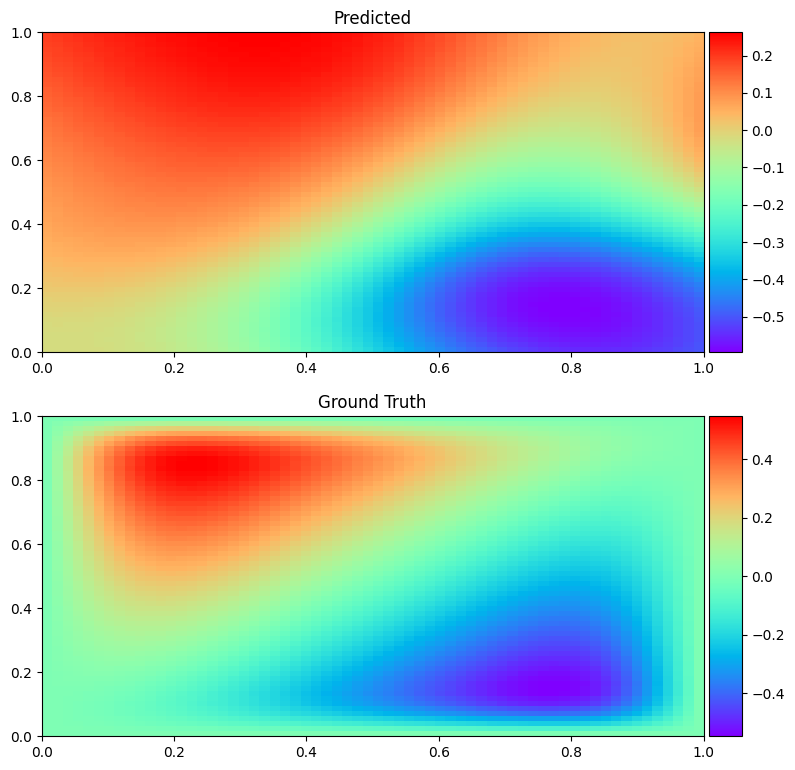

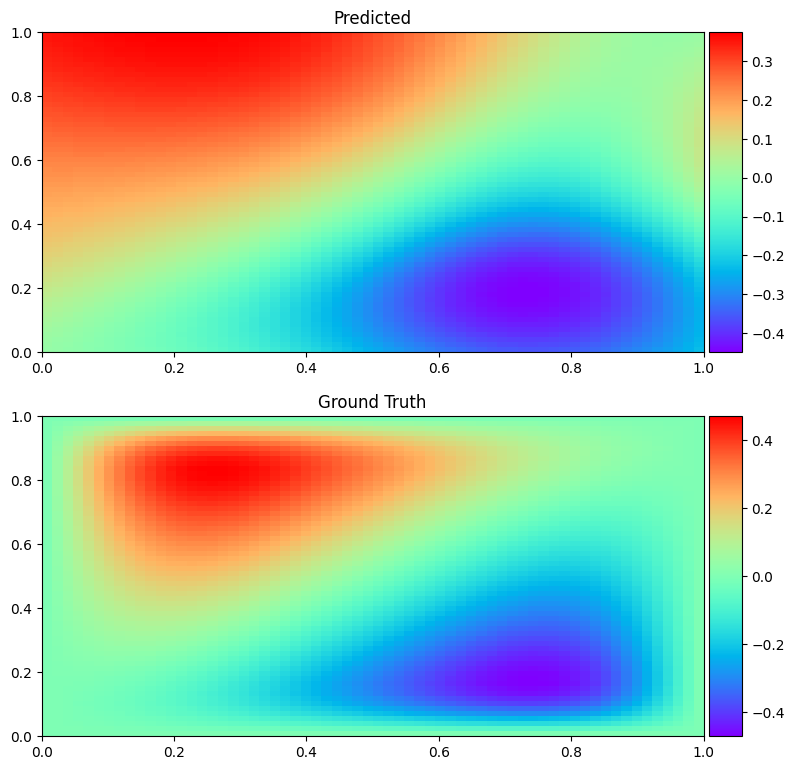

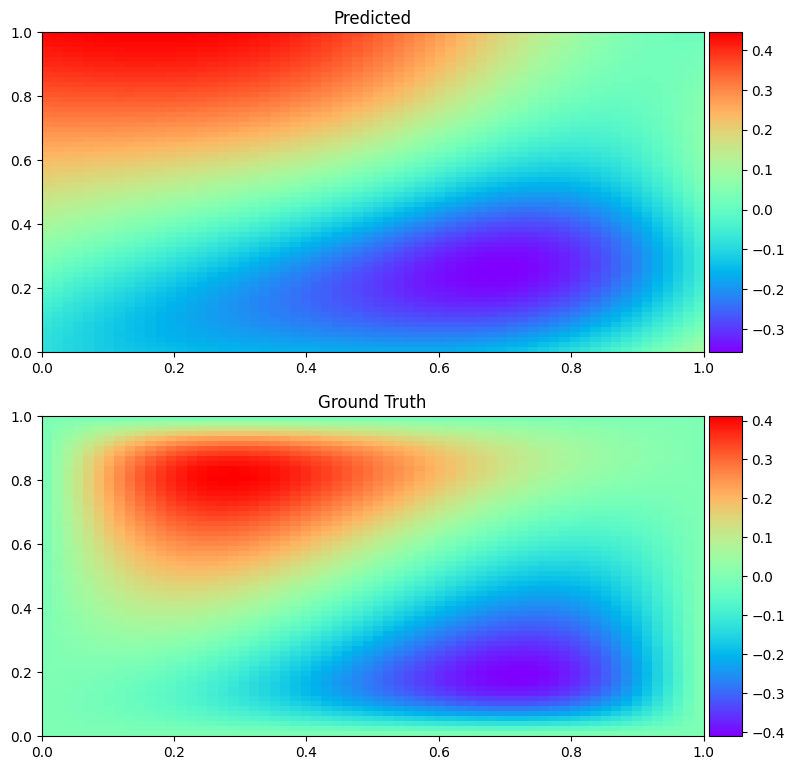

Error y:  0.5622375789478231
model is loading...Done.


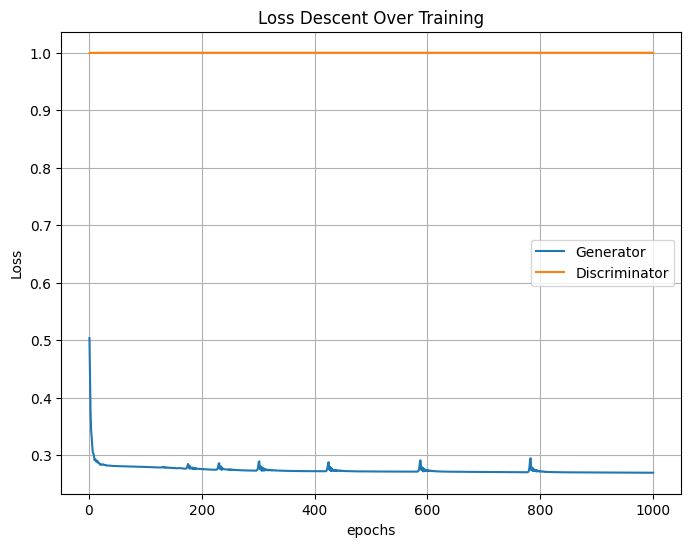

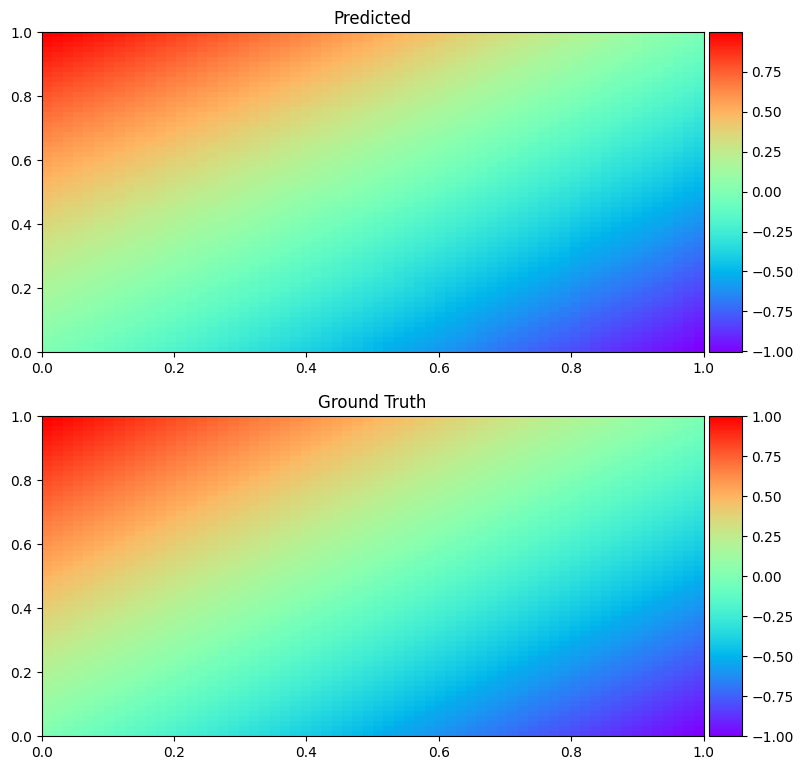

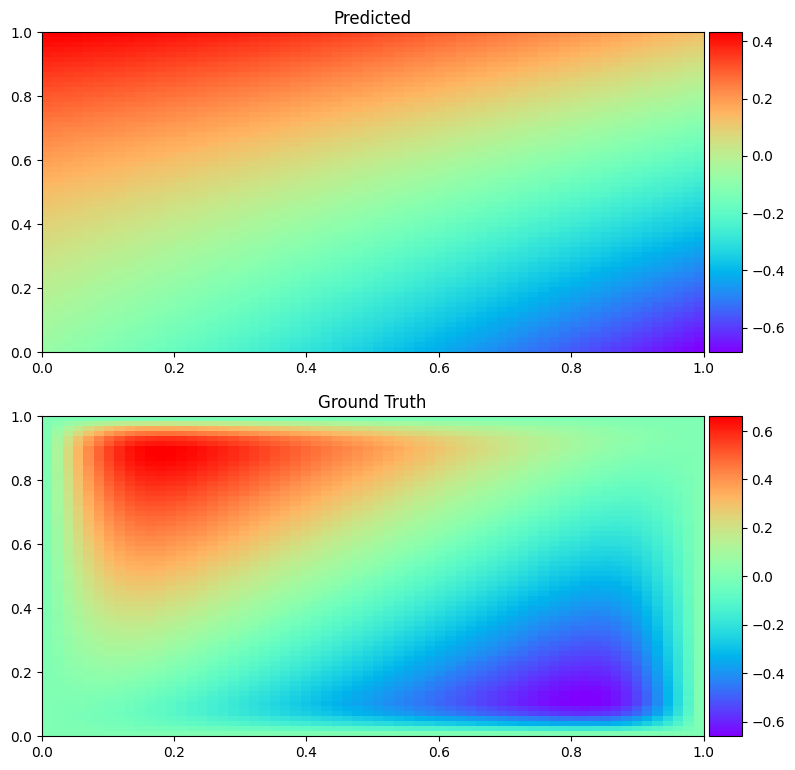

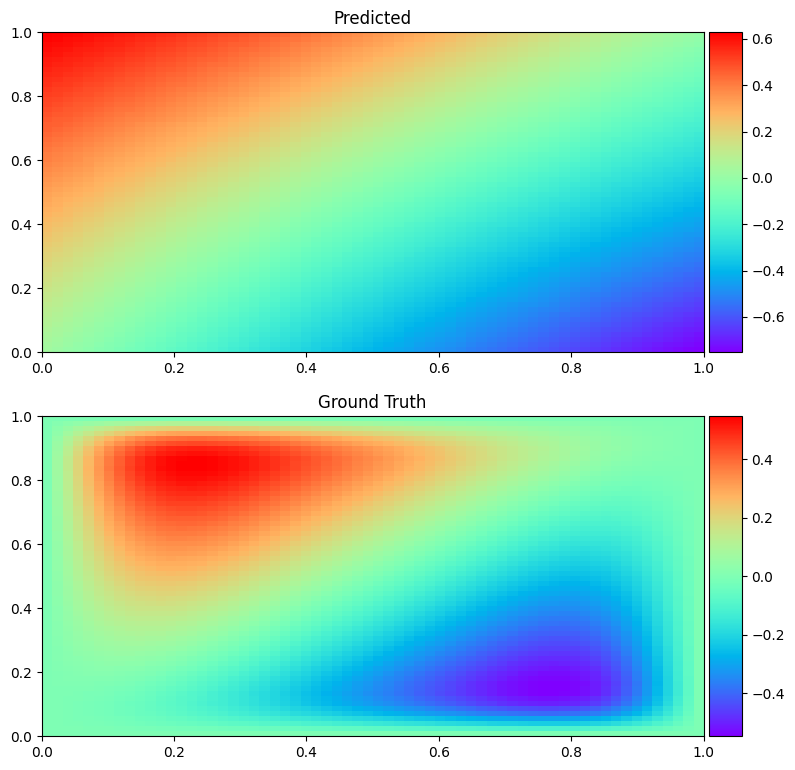

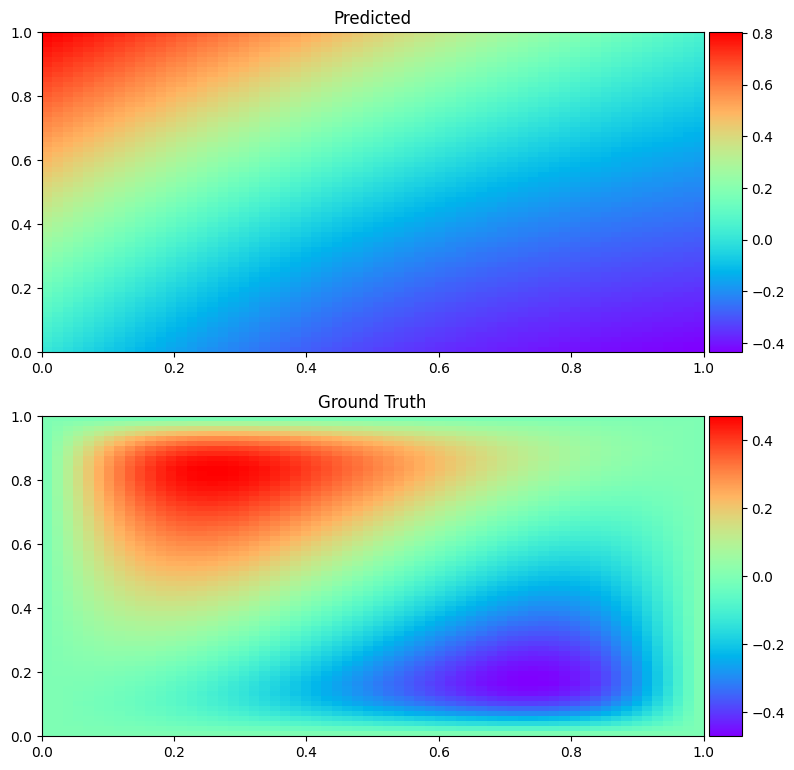

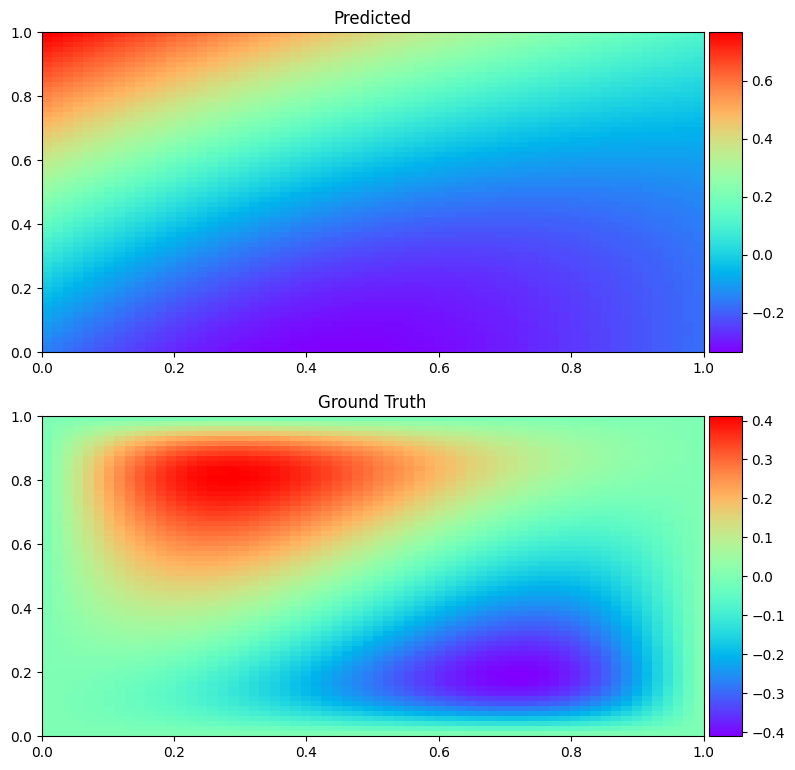

Error y:  0.6855531821167713
model is loading...Done.


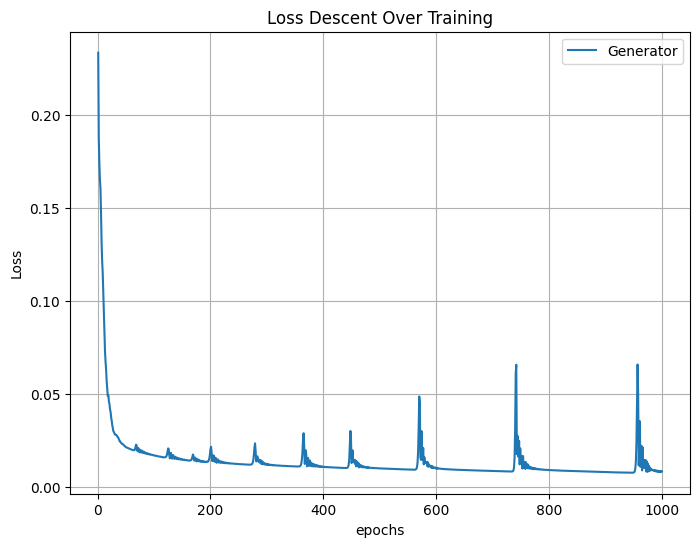

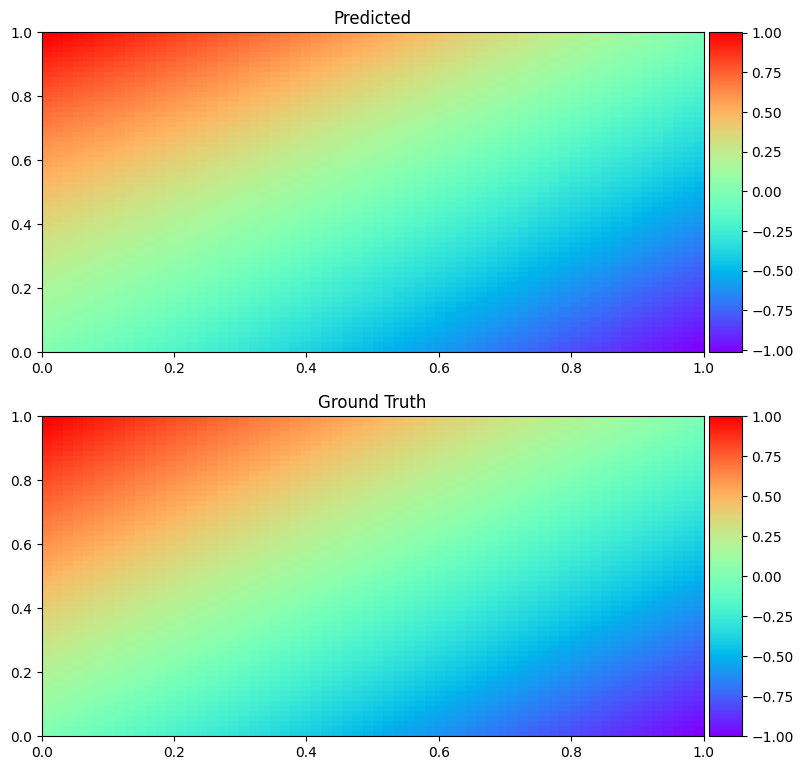

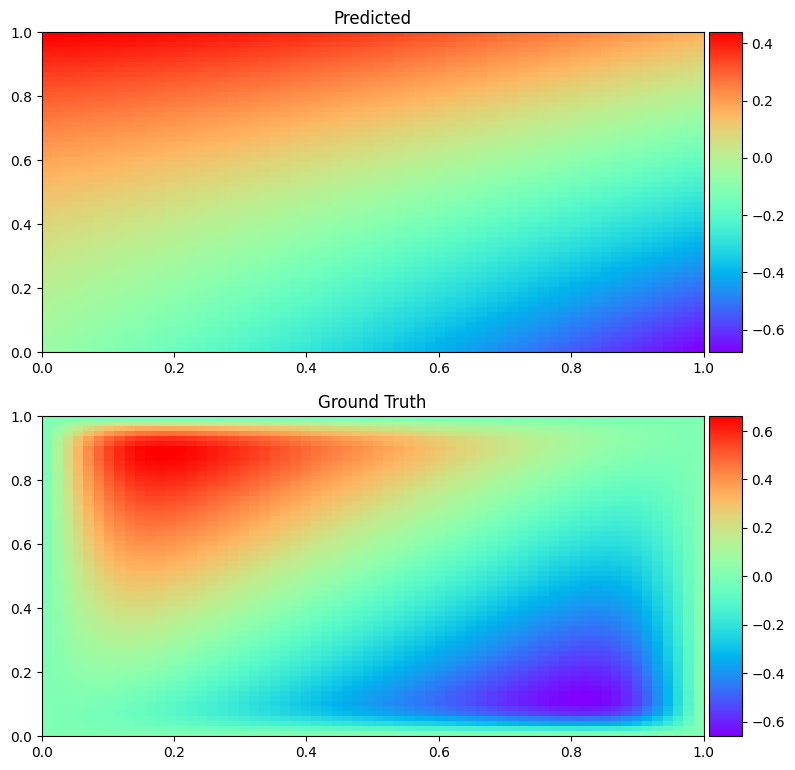

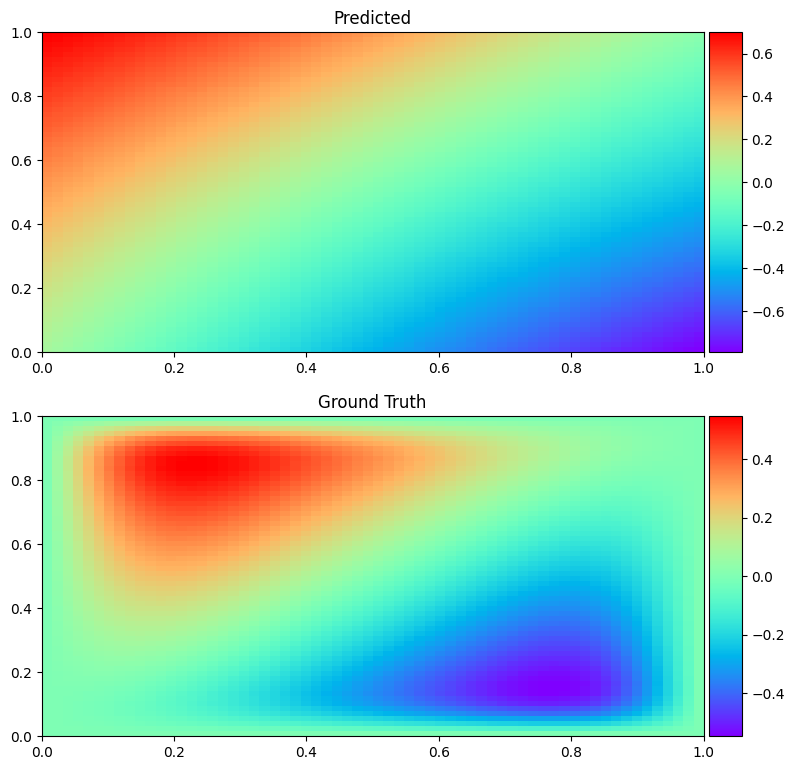

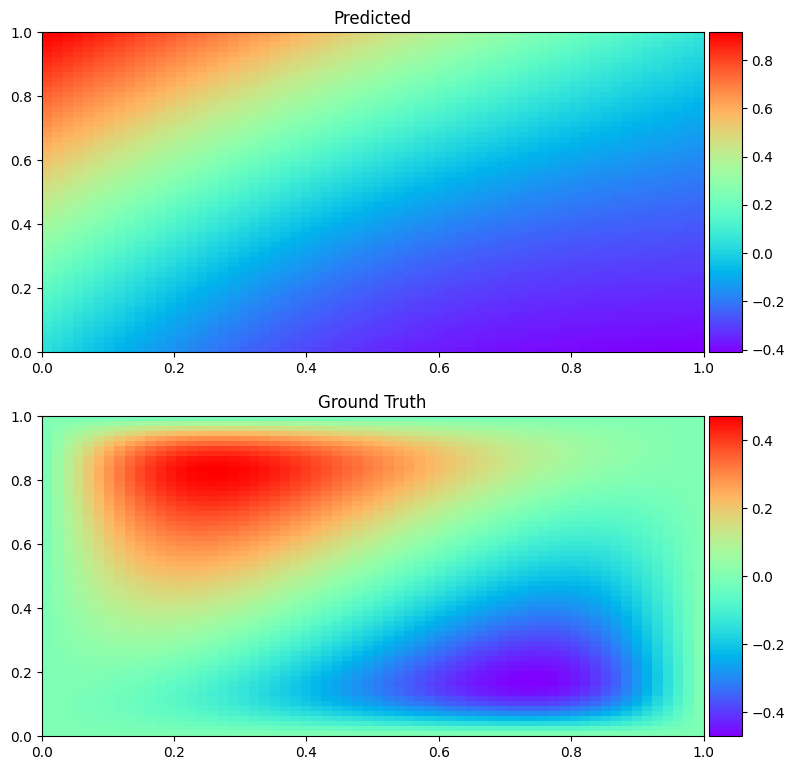

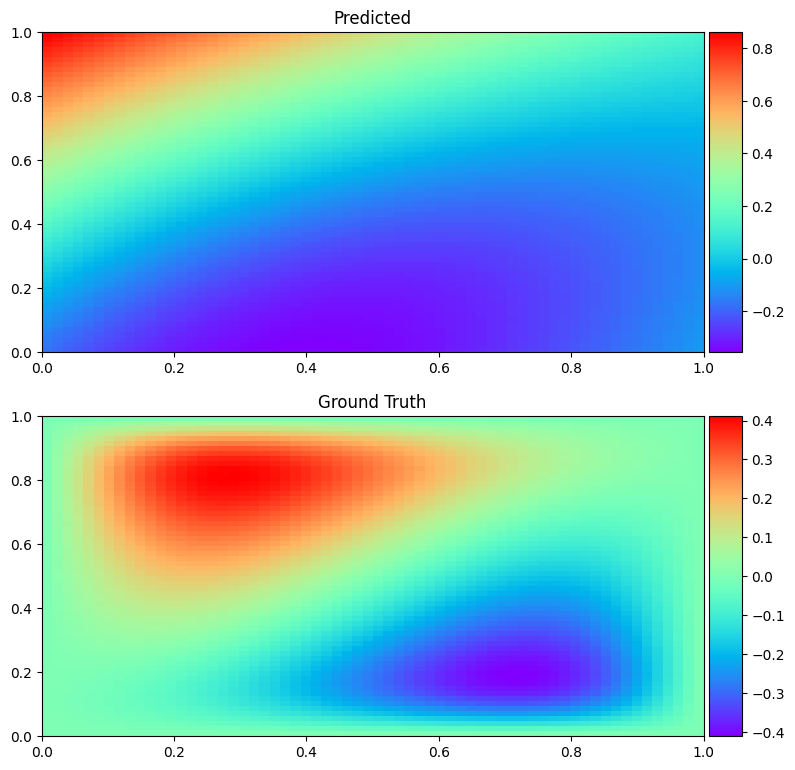

Error y:  0.739811922576277


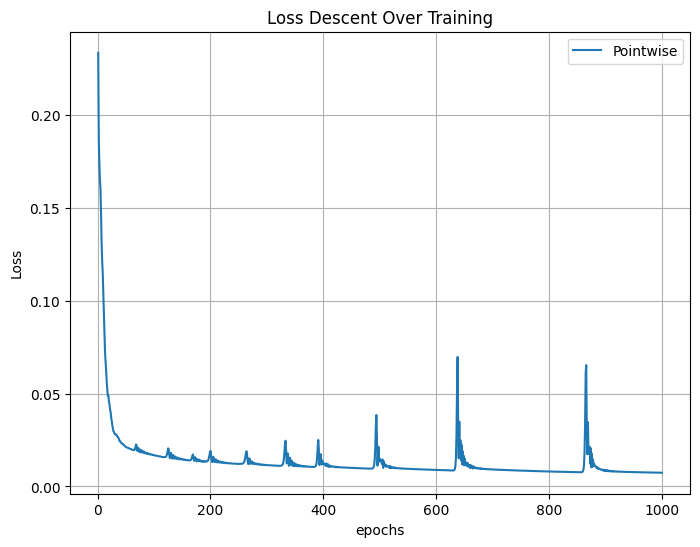

In [2]:
# Hyperparameters
noise = 0.0        
N0 = 50 # number of data for initial samples
N_b = 50 # number of data for boundary samples
N_f = 20000 # number of data for collocation points
N_exact = 40 # number of data points that are passed with their exact solutions

# Define the physics-informed neural network
layers_G = [2, 100, 100, 100, 100, 1] # first entry should be X.shape[0], last entry should be Y.shape[0]
layers_D = [3, 100, 1] # input should be X.shape[0]+Y.shape[0], output 1.

pde = 'heat'

# Load data from simulated dataset
data = scipy.io.loadmat('./Data/'+pde+'.mat')

# structure data
grid, X0, Y0, X_f, X_t, Y_t, X_lb, X_ub, boundary, X_star, Y_star = structure_data(pde, data, noise, N0, N_b, N_f, N_exact)

layers_G[0] = 3
layers_G[-1] = 1
layers_D[0] = 4

model_name = ["heat_paperhyperparams-smaller-e-with-all", 
               "heat_paperhyperparams-smaller-e-with-gan",
               "heat_paperhyperparams-smaller-e-with-none",
               "heat_paperhyperparams-smaller-e-with-pw"]

intermediary_pictures = False
enable_GAN = [True, True, False, False]
enable_PW = [True, False, False, True]
lambdas = [1, 1]
lr = (1e-3, 1e-3, 5e-3)
e = 5e-4
epoch = 999

for i in range(4):
    model = Heat_PINN_GAN(X0, Y0, X_f, X_t, Y_t, X_lb, X_ub, boundary, \
                 layers_G= layers_G, layers_D = layers_D, \
                    intermediary_pictures=intermediary_pictures, enable_GAN = enable_GAN[i], 
                    enable_PW = enable_PW[i], dynamic_lr = False, model_name = model_name[i], \
                        lambdas = lambdas, lr = lr, e = [e]+[5e-6], q = [10e-4]+[5e-5])
    model.load("Saves/"+model_name[i]+"_"+str(epoch)+".pth")
    
    # Predictions
    y_pred, f_pred = model.predict(torch.tensor(X_star, requires_grad=True))
    
    if not intermediary_pictures:
        with open("Saves/last_output_"+model_name[i]+".pkl", "rb") as f:
            mat = pickle.load(f)
        
        X1, X2, _ = grid #NOTE: visualisation will be less meaningfull
        
        nX1, nX2, nT = X1.shape
        # nPixels = X1.shape[0]*X1.shape[1]
        for t in range(0, nT, 10):
            x1 = np.linspace(boundary[0, 0], boundary[1, 0], nX1, endpoint = True)[None, :]
            x2 = np.linspace(boundary[0, 1], boundary[1, 1], nX2, endpoint = True)[None, :]

            x1, x2 =np.meshgrid(x1, x2)
            x_star_m = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))
            y_pred_m = y_pred.reshape(X1.shape)[:,:,t]
            y_star_m = Y_star.reshape(X1.shape)[:,:,t]
            plot_with_ground_truth(y_pred_m, x_star_m, x1, x2, y_star_m, ground_truth_ref=False, 
                                    ground_truth_refpts=[], filename = "Plots/heat_map_" + model_name[i] + "_" + str(t) +".png") # TODO y_star dimensionality
            # plot errors
        with open('Saves/loss_history_'+model_name[i]+'.pkl', 'rb') as f:
            loaded_dict = pickle.load(f)
        plot_loss(loaded_dict,'Plots/'+model_name[i]+'loss_history.png', show_figure = False)
    
    print("Error y: ", np.linalg.norm(Y_star-y_pred,2)/np.linalg.norm(Y_star,2))

In [3]:
loaded_dict.keys()

dict_keys(['Generator', 'Discriminator', 'Pointwise', 'epoch'])